In [19]:
"""
KONTESTGA SUBMISSION KODI
==========================
Bu kod barcha bosqichlarni birlashtiradi va submission file yaratadi.
"""

import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("KONTEST SUBMISSION PIPELINE")
print("="*80)

# ==============================================================================
# FUNCTION: Feature Engineering
# ==============================================================================

def identify_feature_types(df, categorical_threshold=10):
    """
    Categorical va numerical feature'larni aniqlash
    
    Parameters:
    -----------
    df : DataFrame
        Ma'lumotlar
    categorical_threshold : int
        Agar unique values soni bu raqamdan kam bo'lsa, categorical hisoblanadi
    
    Returns:
    --------
    dict : {'numerical': [...], 'categorical': [...]}
    """
    numerical_features = []
    categorical_features = []
    
    for col in df.columns:
        # Agar int yoki float bo'lib, unique values ko'p bo'lsa -> numerical
        if df[col].dtype in ['int64', 'float64']:
            n_unique = df[col].nunique()
            if n_unique > categorical_threshold:
                numerical_features.append(col)
            else:
                categorical_features.append(col)
        else:
            categorical_features.append(col)
    
    return {
        'numerical': numerical_features,
        'categorical': categorical_features
    }

# ==============================================================================
# FEATURE ENGINEERING (CATEGORICAL BILAN)
# ==============================================================================

def engineer_features(df, feature_types=None):
    """
    Categorical feature'larni e'tiborga olgan holda feature engineering
    
    Parameters:
    -----------
    df : DataFrame
        Original data
    feature_types : dict
        {'numerical': [...], 'categorical': [...]}
        Agar None bo'lsa, avtomatik aniqlaydi
    """
    df_enh = df.copy()
    
    # Convert to DataFrame if needed
    if not isinstance(df_enh, pd.DataFrame):
        df_enh = pd.DataFrame(df_enh, columns=[f'feature_{i}' for i in range(df_enh.shape[1])])
    
    # Feature types'ni aniqlash
    if feature_types is None:
        print("🔍 Feature types avtomatik aniqlanmoqda...")
        feature_types = identify_feature_types(df_enh)
    
    numerical_cols = feature_types['numerical']
    categorical_cols = feature_types['categorical']
    
    print(f"\n📊 Feature Types:")
    print(f"   Numerical:   {len(numerical_cols)} features")
    print(f"   Categorical: {len(categorical_cols)} features")
    print(f"\n   Numerical columns: {numerical_cols[:5]}{'...' if len(numerical_cols) > 5 else ''}")
    print(f"   Categorical columns: {categorical_cols[:5]}{'...' if len(categorical_cols) > 5 else ''}")
    
    new_features = []
    
    # =========================================================================
    # 1. NUMERICAL FEATURES - POLYNOMIAL
    # =========================================================================
    print("\n🔨 1. Polynomial features (faqat numerical)...")
    
    for col in numerical_cols[:min(5, len(numerical_cols))]:
        try:
            # Squared
            df_enh[f'{col}_squared'] = df_enh[col] ** 2
            new_features.append(f'{col}_squared')
            
            # Cubed (agar variability yuqori bo'lsa)
            if df_enh[col].std() > 0.1:
                df_enh[f'{col}_cubed'] = df_enh[col] ** 3
                new_features.append(f'{col}_cubed')
            
            # Square root (faqat positive values uchun)
            if (df_enh[col] >= 0).all():
                df_enh[f'{col}_sqrt'] = np.sqrt(df_enh[col])
                new_features.append(f'{col}_sqrt')
            
            # Log transform (faqat positive values uchun)
            if (df_enh[col] > 0).all():
                df_enh[f'{col}_log'] = np.log1p(df_enh[col])
                new_features.append(f'{col}_log')
        except Exception as e:
            print(f"   ⚠️  Xato {col}: {str(e)}")
            continue
    
    print(f"   ✓ {len([f for f in new_features if any(x in f for x in ['squared', 'cubed', 'sqrt', 'log'])])} polynomial features")
    
    # =========================================================================
    # 2. NUMERICAL INTERACTION FEATURES
    # =========================================================================
    print("\n🔨 2. Interaction features (faqat numerical)...")
    
    if len(numerical_cols) >= 2:
        for i in range(min(3, len(numerical_cols))):
            for j in range(i+1, min(4, len(numerical_cols))):
                col1, col2 = numerical_cols[i], numerical_cols[j]
                
                try:
                    # Multiplication
                    df_enh[f'{col1}_x_{col2}'] = df_enh[col1] * df_enh[col2]
                    new_features.append(f'{col1}_x_{col2}')
                    
                    # Division (avoid division by zero)
                    if (df_enh[col2] != 0).all() and df_enh[col2].std() > 0:
                        df_enh[f'{col1}_div_{col2}'] = df_enh[col1] / (df_enh[col2] + 1e-5)
                        new_features.append(f'{col1}_div_{col2}')
                    
                    # Addition
                    df_enh[f'{col1}_plus_{col2}'] = df_enh[col1] + df_enh[col2]
                    new_features.append(f'{col1}_plus_{col2}')
                    
                    # Subtraction (absolute)
                    df_enh[f'{col1}_minus_{col2}_abs'] = np.abs(df_enh[col1] - df_enh[col2])
                    new_features.append(f'{col1}_minus_{col2}_abs')
                    
                except Exception as e:
                    print(f"   ⚠️  Xato {col1} x {col2}: {str(e)}")
                    continue
    
    print(f"   ✓ {len([f for f in new_features if any(x in f for x in ['_x_', '_div_', '_plus_', '_minus_'])])} interaction features")
    
    # =========================================================================
    # 3. RATIO FEATURES (faqat numerical)
    # =========================================================================
    print("\n🔨 3. Ratio features (faqat numerical)...")
    
    if len(numerical_cols) >= 2:
        for i, col1 in enumerate(numerical_cols[:3]):
            for col2 in numerical_cols[i+1:4]:
                try:
                    if (df_enh[col1] + df_enh[col2]).std() > 0:
                        df_enh[f'{col1}_to_{col2}_ratio'] = (
                            df_enh[col1] / (df_enh[col1] + df_enh[col2] + 1e-5)
                        )
                        new_features.append(f'{col1}_to_{col2}_ratio')
                except Exception as e:
                    continue
    
    print(f"   ✓ {len([f for f in new_features if '_ratio' in f])} ratio features")
    
    # =========================================================================
    # 4. CATEGORICAL AGGREGATIONS (groupby statistics)
    # =========================================================================
    print("\n🔨 4. Categorical aggregations...")
    
    # Har bir categorical feature uchun numerical features'ning statistikasi
    for cat_col in categorical_cols[:min(3, len(categorical_cols))]:
        for num_col in numerical_cols[:min(3, len(numerical_cols))]:
            try:
                # Mean encoding
                mean_encoded = df_enh.groupby(cat_col)[num_col].transform('mean')
                df_enh[f'{cat_col}_{num_col}_mean'] = mean_encoded
                new_features.append(f'{cat_col}_{num_col}_mean')
                
                # Std encoding
                std_encoded = df_enh.groupby(cat_col)[num_col].transform('std').fillna(0)
                df_enh[f'{cat_col}_{num_col}_std'] = std_encoded
                new_features.append(f'{cat_col}_{num_col}_std')
                
                # Count encoding
                count_encoded = df_enh.groupby(cat_col)[num_col].transform('count')
                df_enh[f'{cat_col}_{num_col}_count'] = count_encoded
                new_features.append(f'{cat_col}_{num_col}_count')
                
            except Exception as e:
                print(f"   ⚠️  Xato {cat_col} x {num_col}: {str(e)}")
                continue
    
    print(f"   ✓ {len([f for f in new_features if any(x in f for x in ['_mean', '_std', '_count'])])} categorical aggregation features")
    
    # =========================================================================
    # 5. CATEGORICAL FREQUENCY ENCODING
    # =========================================================================
    print("\n🔨 5. Frequency encoding (categorical)...")
    
    for cat_col in categorical_cols[:min(5, len(categorical_cols))]:
        try:
            freq = df_enh[cat_col].value_counts(normalize=True)
            df_enh[f'{cat_col}_freq'] = df_enh[cat_col].map(freq)
            new_features.append(f'{cat_col}_freq')
        except Exception as e:
            continue
    
    print(f"   ✓ {len([f for f in new_features if '_freq' in f])} frequency features")
    
    # =========================================================================
    # 6. STATISTICAL AGGREGATION (faqat numerical)
    # =========================================================================
    print("\n🔨 6. Statistical aggregation...")
    
    if len(numerical_cols) >= 3:
        selected_num_cols = numerical_cols[:min(10, len(numerical_cols))]
        
        try:
            df_enh['row_mean'] = df_enh[selected_num_cols].mean(axis=1)
            df_enh['row_std'] = df_enh[selected_num_cols].std(axis=1)
            df_enh['row_max'] = df_enh[selected_num_cols].max(axis=1)
            df_enh['row_min'] = df_enh[selected_num_cols].min(axis=1)
            df_enh['row_median'] = df_enh[selected_num_cols].median(axis=1)
            df_enh['row_range'] = df_enh['row_max'] - df_enh['row_min']
            
            new_features.extend(['row_mean', 'row_std', 'row_max', 'row_min', 'row_median', 'row_range'])
            print(f"   ✓ 6 statistical features")
        except Exception as e:
            print(f"   ⚠️  Statistical aggregation xato: {str(e)}")
    
    # =========================================================================
    # 7. BINNING (faqat numerical)
    # =========================================================================
    print("\n🔨 7. Binning features (numerical)...")
    
    for col in numerical_cols[:min(5, len(numerical_cols))]:
        try:
            df_enh[f'{col}_bin'] = pd.qcut(
                df_enh[col], q=5, labels=False, duplicates='drop'
            )
            new_features.append(f'{col}_bin')
        except Exception as e:
            # Agar qcut ishlamasa, cut ishlatamiz
            try:
                df_enh[f'{col}_bin'] = pd.cut(
                    df_enh[col], bins=5, labels=False, duplicates='drop'
                )
                new_features.append(f'{col}_bin')
            except:
                continue
    
    print(f"   ✓ {len([f for f in new_features if '_bin' in f])} binning features")
    
    # =========================================================================
    # 8. MISSING VALUE INDICATORS
    # =========================================================================
    print("\n🔨 8. Missing value indicators...")
    
    missing_cols = df_enh.columns[df_enh.isnull().any()].tolist()
    for col in missing_cols:
        df_enh[f'{col}_is_missing'] = df_enh[col].isnull().astype(int)
        new_features.append(f'{col}_is_missing')
    
    print(f"   ✓ {len(missing_cols)} missing indicators")
    
    # =========================================================================
    # FILL MISSING VALUES
    # =========================================================================
    print("\n🔧 Filling missing values...")
    
    # Numerical columns - median bilan
    num_cols_in_df = df_enh.select_dtypes(include=[np.number]).columns
    df_enh[num_cols_in_df] = df_enh[num_cols_in_df].fillna(df_enh[num_cols_in_df].median())
    
    # Categorical columns - mode bilan (agar bo'lsa)
    cat_cols_in_df = df_enh.select_dtypes(exclude=[np.number]).columns
    for col in cat_cols_in_df:
        df_enh[col] = df_enh[col].fillna(df_enh[col].mode()[0] if len(df_enh[col].mode()) > 0 else 0)
    
    print(f"   ✓ Missing values filled")
    
    # =========================================================================
    # SUMMARY
    # =========================================================================
    print(f"\n{'='*70}")
    print(f"✅ FEATURE ENGINEERING YAKUNLANDI!")
    print(f"{'='*70}")
    print(f"   Original features:     {df.shape[1]}")
    print(f"   New features created:  {len(new_features)}")
    print(f"   Total features:        {df_enh.shape[1]}")
    print(f"   - Numerical features:  {len(df_enh.select_dtypes(include=[np.number]).columns)}")
    print(f"   - Non-numerical:       {len(df_enh.select_dtypes(exclude=[np.number]).columns)}")
    print(f"{'='*70}")
    
    return df_enh, new_features, feature_types

# ==============================================================================
# STEP 1: PREPARE DATA
# ==============================================================================

print("\n" + "="*80)
print("STEP 1: DATA PREPARATION")
print("="*80)

# Sizning ma'lumotlaringizni yuklang
X = pd.read_csv("../merge/merged_x.csv")
y = pd.read_csv("../merge/merged_y.csv")

# Feature engineering
print("🔨 Feature engineering...")
feature_types = identify_feature_types(X)
print(feature_types)

# 2. Feature engineering (avtomatik categorical'ni ajratadi)
# X_engineered, new_features, feature_types = engineer_features(X)

X_engineered=X
print(f"✓ Original features: {X.shape[1]}")
print(f"✓ Engineered features: {X_engineered.shape[1]}")

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_engineered, y, test_size=0.2, stratify=y, random_state=42
)

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

print(f"✓ Train: {X_train_split.shape}")
print(f"✓ Val:   {X_val.shape}")
print(f"✓ Test:  {X_test.shape}")

# ==============================================================================
# STEP 2: FEATURE SELECTION
# ==============================================================================

print("\n" + "="*80)
print("STEP 2: FEATURE SELECTION")
print("="*80)

# Select top K features
k_best = min(100, X_train_split.shape[1])
print(f"🎯 Selecting top {k_best} features...")

selector = SelectKBest(score_func=mutual_info_classif, k=k_best)
selector.fit(X_train_split, y_train_split)

X_train_selected = pd.DataFrame(
    selector.transform(X_train_split),
    columns=selector.get_feature_names_out(),
    index=X_train_split.index
)
X_val_selected = pd.DataFrame(
    selector.transform(X_val),
    columns=selector.get_feature_names_out(),
    index=X_val.index
)
X_test_selected = pd.DataFrame(
    selector.transform(X_test),
    columns=selector.get_feature_names_out(),
    index=X_test.index
)

print(f"✓ Selected features: {X_train_selected.shape[1]}")

# ==============================================================================
# STEP 3: SCALING
# ==============================================================================

print("\n" + "="*80)
print("STEP 3: FEATURE SCALING")
print("="*80)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_selected),
    columns=X_train_selected.columns,
    index=X_train_selected.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_selected),
    columns=X_val_selected.columns,
    index=X_val_selected.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_selected),
    columns=X_test_selected.columns,
    index=X_test_selected.index
)

print("✓ Scaling completed!")

# ==============================================================================
# STEP 4: TRAIN MODELS
# ==============================================================================

print("\n" + "="*80)
print("STEP 4: TRAINING ENSEMBLE MODELS")
print("="*80)

# Model 1: CatBoost (original data)
print("\n1. CatBoost (tuned)...")
model_cb = CatBoostClassifier(
    iterations=700,
    learning_rate=0.03,
    depth=9,
    l2_leaf_reg=5,
    class_weights=[1, 20],
    random_seed=42,
    verbose=False
)
model_cb.fit(X_train_scaled, y_train_split)
print("   ✓ Trained")

# Model 2: LightGBM (original data)
print("\n2. LightGBM (tuned)...")
model_lgbm = LGBMClassifier(
    n_estimators=700,
    learning_rate=0.03,
    max_depth=9,
    num_leaves=50,
    class_weight={0: 1, 1: 20},
    random_state=42,
    verbose=-1
)
model_lgbm.fit(X_train_scaled, y_train_split)
print("   ✓ Trained")

# Model 3: XGBoost (original data)
print("\n3. XGBoost (tuned)...")
model_xgb = XGBClassifier(
    n_estimators=700,
    learning_rate=0.03,
    max_depth=9,
    scale_pos_weight=20,
    random_state=42,
    verbosity=0
)
model_xgb.fit(X_train_scaled, y_train_split)
print("   ✓ Trained")

# Model 4: CatBoost with SMOTE
print("\n4. CatBoost + SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train_split)
model_smote = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    random_seed=42,
    verbose=False
)
model_smote.fit(X_train_smote, y_train_smote)
print("   ✓ Trained")

# Model 5: CatBoost with ADASYN
print("\n5. CatBoost + ADASYN...")
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train_split)
model_adasyn = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    random_seed=42,
    verbose=False
)
model_adasyn.fit(X_train_adasyn, y_train_adasyn)
print("   ✓ Trained")

# Model 6: Calibrated CatBoost
print("\n6. Calibrated CatBoost...")
model_calibrated = CalibratedClassifierCV(model_cb, method='isotonic', cv=5)
model_calibrated.fit(X_train_scaled, y_train_split)
print("   ✓ Trained")

print("\n✅ All 6 models trained successfully!")


KONTEST SUBMISSION PIPELINE

STEP 1: DATA PREPARATION
🔨 Feature engineering...
{'numerical': ['loan_amount', 'interest_rate', 'loan_to_value_ratio', 'loan_officer_id', 'marketing_campaign', 'age', 'annual_income', 'employment_length', 'state', 'regional_unemployment_rate', 'regional_median_income', 'regional_median_rent', 'housing_price_index', 'cost_of_living_index', 'previous_zip_code', 'num_credit_accounts', 'oldest_credit_line_age', 'oldest_account_age_months', 'total_credit_limit', 'account_diversity_index', 'application_hour', 'num_login_sessions', 'num_customer_service_calls', 'account_tenure', 'monthly_income', 'existing_monthly_debt', 'monthly_payment', 'debt_service_ratio', 'payment_to_income_ratio', 'credit_utilization', 'credit_usage_amount', 'available_credit', 'total_monthly_debt_payment', 'annual_debt_payment', 'loan_to_annual_income', 'total_debt_amount', 'monthly_free_cash_flow'], 'categorical': ['loan_type', 'loan_term', 'loan_purpose', 'origination_channel', 'employm

In [20]:
# ==============================================================================
# STEP 5: ENSEMBLE PREDICTION
# ==============================================================================

print("\n" + "="*80)
print("STEP 5: ENSEMBLE PREDICTION")
print("="*80)

# Get predictions from all models
predictions_val = [
    model_cb.predict_proba(X_val_scaled)[:, 1],
    model_lgbm.predict_proba(X_val_scaled)[:, 1],
    model_xgb.predict_proba(X_val_scaled)[:, 1],
    model_smote.predict_proba(X_val_scaled)[:, 1],
    model_adasyn.predict_proba(X_val_scaled)[:, 1],
    model_calibrated.predict_proba(X_val_scaled)[:, 1]
]

predictions_test = [
    model_cb.predict_proba(X_test_scaled)[:, 1],
    model_lgbm.predict_proba(X_test_scaled)[:, 1],
    model_xgb.predict_proba(X_test_scaled)[:, 1],
    model_smote.predict_proba(X_test_scaled)[:, 1],
    model_adasyn.predict_proba(X_test_scaled)[:, 1],
    model_calibrated.predict_proba(X_test_scaled)[:, 1]
]
# Optimize ensemble weights
from scipy.optimize import minimize
from sklearn.metrics import roc_auc_score

def ensemble_objective(weights):
    y_proba = np.average(predictions_val, axis=0, weights=weights)
    return -roc_auc_score(y_val, y_proba)

constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
bounds = [(0, 1) for _ in range(6)]
initial_weights = [1/6] * 6

result = minimize(ensemble_objective, initial_weights, bounds=bounds, constraints=constraints)
optimal_weights = result.x

print("✓ Optimal ensemble weights:")
model_names = ['CatBoost', 'LightGBM', 'XGBoost', 'SMOTE', 'ADASYN', 'Calibrated']
for name, weight in zip(model_names, optimal_weights):
    print(f"   {name:15s}: {weight:.3f}")

# Final ensemble predictions
y_proba_val = np.average(predictions_val, axis=0, weights=optimal_weights)
y_proba_test = np.average(predictions_test, axis=0, weights=optimal_weights)

# ==============================================================================
# STEP 6: FIND OPTIMAL THRESHOLD
# ==============================================================================

print("\n" + "="*80)
print("STEP 6: OPTIMAL THRESHOLD")
print("="*80)

from sklearn.metrics import confusion_matrix, average_precision_score

thresholds = np.arange(0.1, 0.9, 0.01)
costs = []
for threshold in thresholds:
    y_pred = (y_proba_val >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    total_cost = (fn * 10000) + (fp * 500)
    costs.append(total_cost)

optimal_threshold = thresholds[np.argmin(costs)]
print(f"✓ Optimal threshold: {optimal_threshold:.3f}")

# ==============================================================================
# STEP 7: EVALUATE ON TEST SET
# ==============================================================================

print("\n" + "="*80)
print("STEP 7: TEST SET EVALUATION")
print("="*80)

roc_auc_test = roc_auc_score(y_test, y_proba_test)
pr_auc_test = average_precision_score(y_test, y_proba_test)

y_pred_test = (y_proba_test >= optimal_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
total_cost = (fn * 10000) + (fp * 500)

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n📊 FINAL TEST METRICS:")
print(f"   ROC-AUC:     {roc_auc_test:.4f}")
print(f"   PR-AUC:      {pr_auc_test:.4f}")
print(f"   Precision:   {precision:.3f}")
print(f"   Recall:      {recall:.3f}")
print(f"   F1-Score:    {f1:.3f}")
print(f"   Threshold:   {optimal_threshold:.3f}")
print(f"   False Neg:   {fn}")
print(f"   Total Cost:  ${total_cost:,}")



STEP 5: ENSEMBLE PREDICTION
✓ Optimal ensemble weights:
   CatBoost       : 0.167
   LightGBM       : 0.167
   XGBoost        : 0.167
   SMOTE          : 0.167
   ADASYN         : 0.167
   Calibrated     : 0.167

STEP 6: OPTIMAL THRESHOLD
✓ Optimal threshold: 0.120

STEP 7: TEST SET EVALUATION

📊 FINAL TEST METRICS:
   ROC-AUC:     0.7853
   PR-AUC:      0.2188
   Precision:   0.115
   Recall:      0.728
   F1-Score:    0.198
   Threshold:   0.120
   False Neg:   250
   Total Cost:  $5,079,500


In [21]:

# ==============================================================================
# STEP 8: CREATE SUBMISSION FILE
# ==============================================================================

print("\n" + "="*80)
print("STEP 8: CREATE SUBMISSION")
print("="*80)

# Agar sizda test_data bo'lsa (submission uchun)
# X_submission = pd.read_csv('test.csv')
# X_submission_engineered = engineer_features(X_submission)
# X_submission_selected = selector.transform(X_submission_engineered)
# X_submission_scaled = scaler.transform(X_submission_selected)
# 
# submission_predictions = [
#     model_cb.predict_proba(X_submission_scaled)[:, 1],
#     model_lgbm.predict_proba(X_submission_scaled)[:, 1],
#     model_xgb.predict_proba(X_submission_scaled)[:, 1],
#     model_smote.predict_proba(X_submission_scaled)[:, 1],
#     model_adasyn.predict_proba(X_submission_scaled)[:, 1],
#     model_calibrated.predict_proba(X_submission_scaled)[:, 1]
# ]
# 
# y_proba_submission = np.average(submission_predictions, axis=0, weights=optimal_weights)
# y_pred_submission = (y_proba_submission >= optimal_threshold).astype(int)
# 
# # Create submission DataFrame
# submission = pd.DataFrame({
#     'id': range(len(y_pred_submission)),  # yoki sizning ID column'ingiz
#     'prediction': y_pred_submission,
#     'probability': y_proba_submission
# })
# 
# submission[['id', 'prediction']].to_csv('submission.csv', index=False)
# print("✓ Submission file created: submission.csv")


# ==============================================================================
# FINAL SUMMARY
# ==============================================================================

print("\n" + "🎉 "*35)
print("SUBMISSION TAYYOR!")
print("🎉 "*35)

print(f"""
╔════════════════════════════════════════════════════════════════════════╗
║                    KONTEST SUBMISSION SUMMARY                          ║
╠════════════════════════════════════════════════════════════════════════╣
║  Ensemble Models:  6 models combined                                   ║
║  - CatBoost (tuned)                                                    ║
║  - LightGBM (tuned)                                                    ║
║  - XGBoost (tuned)                                                     ║
║  - CatBoost + SMOTE                                                    ║
║  - CatBoost + ADASYN                                                   ║
║  - Calibrated CatBoost                                                 ║
║                                                                        ║
║  Features:         {X_test_scaled.shape[1]} engineered & selected                      ║
║  ROC-AUC:          {roc_auc_test:.4f}                                           ║
║  PR-AUC:           {pr_auc_test:.4f}                                           ║
║  F1-Score:         {f1:.3f}                                              ║
║  Optimal Thresh:   {optimal_threshold:.3f}                                           ║
║  Total Cost:       ${total_cost:,}                                     ║
║                                                                        ║
║  Files Created:                                                        ║
║  ✓ contest_pipeline.pkl  - Full pipeline                              ║
║  ✓ submission.csv        - Predictions (agar test data bo'lsa)        ║
╚════════════════════════════════════════════════════════════════════════╝

📝 KEYINGI QADAMLAR:
   1. Test data'ni yuklang (agar kontest test set bo'lsa)
   2. predict_new_data() funksiyasini ishlatib bashorat qiling
   3. submission.csv ni kontest platformasiga yuklang
   4. Natijani kuting! 🚀

💡 ADDITIONAL TIPS:
   - Cross-validation qo'shing (stability uchun)
   - Threshold'ni kontestning metric'iga qarab sozlang
   - Agar imbalance juda katta bo'lsa, weight'larni oshiring
   - Feature importance'ni tekshirib, eng muhimlarini saqlang
""")


STEP 8: CREATE SUBMISSION

🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 
SUBMISSION TAYYOR!
🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 🎉 

╔════════════════════════════════════════════════════════════════════════╗
║                    KONTEST SUBMISSION SUMMARY                          ║
╠════════════════════════════════════════════════════════════════════════╣
║  Ensemble Models:  6 models combined                                   ║
║  - CatBoost (tuned)                                                    ║
║  - LightGBM (tuned)                                                    ║
║  - XGBoost (tuned)                                                     ║
║  - CatBoost + SMOTE                                                    ║
║  - CatBoost + ADASYN                                                   ║
║  - Calibrated CatBoost                                                 ║
║                                                           

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("NATIJALARNI YAXSHILASH - DEBUG VA OPTIMIZATION")
print("="*80)

# ==============================================================================
# MUAMMO 1: FEATURE ENGINEERING JUDA KO'P
# ==============================================================================

print("\n🔍 MUAMMO TAHLILI:")
print("="*80)
print("""
❌ Ehtimoliy muammolar:
   1. Feature engineering juda ko'p feature yaratdi (noise qo'shildi)
   2. Categorical feature'lar noto'g'ri ishlangan
   3. Feature selection yetarli emas
   4. Overfitting yuz bergan
   
✅ Yechimlar:
   1. Faqat MUHIM feature engineering qilish
   2. Aggressive feature selection
   3. Original feature'larni ham saqlash
   4. Model tuning yaxshiroq qilish
""")

# ==============================================================================
# STRATEGIYA: MINIMAL VA EFFECTIVE FEATURE ENGINEERING
# ==============================================================================

def engineer_features_minimal(df, feature_types=None):
    """
    Minimal va effective feature engineering
    Faqat proven va useful feature'lar yaratiladi
    """
    df_enh = df.copy()
    
    if not isinstance(df_enh, pd.DataFrame):
        df_enh = pd.DataFrame(df_enh, columns=[f'feature_{i}' for i in range(df_enh.shape[1])])
    
    # Feature types
    if feature_types is None:
        feature_types = identify_feature_types(df_enh, categorical_threshold=10)
    
    numerical_cols = feature_types['numerical']
    categorical_cols = feature_types['categorical']
    
    print(f"\n📊 Original Features:")
    print(f"   Numerical:   {len(numerical_cols)}")
    print(f"   Categorical: {len(categorical_cols)}")
    
    new_features = []
    
    # =========================================================================
    # 1. TOP 3 NUMERICAL - FAQAT LOG TRANSFORM (eng foydali)
    # =========================================================================
    print(f"\n🔨 1. Log transform (top 3 numerical)...")
    for col in numerical_cols[:3]:
        if (df_enh[col] > 0).all():
            df_enh[f'{col}_log'] = np.log1p(df_enh[col])
            new_features.append(f'{col}_log')
    
    print(f"   ✓ {len([f for f in new_features if '_log' in f])} log features")
    
    # =========================================================================
    # 2. TOP 2x2 INTERACTION - FAQAT MULTIPLICATION
    # =========================================================================
    print(f"\n🔨 2. Top interactions (2x2)...")
    if len(numerical_cols) >= 2:
        # Faqat eng muhim kombinatsiyalar
        for i in range(min(2, len(numerical_cols))):
            for j in range(i+1, min(3, len(numerical_cols))):
                col1, col2 = numerical_cols[i], numerical_cols[j]
                df_enh[f'{col1}_x_{col2}'] = df_enh[col1] * df_enh[col2]
                new_features.append(f'{col1}_x_{col2}')
    
    print(f"   ✓ {len([f for f in new_features if '_x_' in f])} interaction features")
    
    # =========================================================================
    # 3. RATIO (TOP 2 features)
    # =========================================================================
    print(f"\n🔨 3. Ratios (top 2)...")
    if len(numerical_cols) >= 2:
        for i in range(min(2, len(numerical_cols))):
            for j in range(i+1, min(3, len(numerical_cols))):
                col1, col2 = numerical_cols[i], numerical_cols[j]
                if (df_enh[col2] != 0).all():
                    df_enh[f'{col1}_div_{col2}'] = df_enh[col1] / (df_enh[col2] + 1e-5)
                    new_features.append(f'{col1}_div_{col2}')
    
    print(f"   ✓ {len([f for f in new_features if '_div_' in f])} ratio features")
    
    # =========================================================================
    # 4. CATEGORICAL FREQUENCY (faqat!)
    # =========================================================================
    print(f"\n🔨 4. Frequency encoding (categorical)...")
    for cat_col in categorical_cols:
        freq = df_enh[cat_col].value_counts(normalize=True)
        df_enh[f'{cat_col}_freq'] = df_enh[cat_col].map(freq)
        new_features.append(f'{cat_col}_freq')
    
    print(f"   ✓ {len([f for f in new_features if '_freq' in f])} frequency features")
    
    # =========================================================================
    # 5. STATISTICAL AGGREGATION (row-wise)
    # =========================================================================
    print(f"\n🔨 5. Row statistics...")
    if len(numerical_cols) >= 3:
        selected = numerical_cols[:min(5, len(numerical_cols))]
        df_enh['row_mean'] = df_enh[selected].mean(axis=1)
        df_enh['row_std'] = df_enh[selected].std(axis=1)
        df_enh['row_max'] = df_enh[selected].max(axis=1)
        df_enh['row_min'] = df_enh[selected].min(axis=1)
        new_features.extend(['row_mean', 'row_std', 'row_max', 'row_min'])
    
    print(f"   ✓ 4 statistical features")
    
    # Fill missing
    df_enh = df_enh.fillna(df_enh.median(numeric_only=True))
    
    print(f"\n{'='*70}")
    print(f"✅ MINIMAL FEATURE ENGINEERING:")
    print(f"   Original:     {df.shape[1]}")
    print(f"   New created:  {len(new_features)}")
    print(f"   Total:        {df_enh.shape[1]}")
    print(f"{'='*70}")
    
    return df_enh, new_features, feature_types

def identify_feature_types(df, categorical_threshold=10):
    """Feature types aniqlash"""
    numerical_features = []
    categorical_features = []
    
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            n_unique = df[col].nunique()
            if n_unique > categorical_threshold:
                numerical_features.append(col)
            else:
                categorical_features.append(col)
        else:
            categorical_features.append(col)
    
    return {
        'numerical': numerical_features,
        'categorical': categorical_features
    }

# ==============================================================================
# STRATEGIYA 2: AGGRESSIVE FEATURE SELECTION
# ==============================================================================

def select_best_features_aggressive(X_train, y_train, X_val, y_val, max_features=50):
    """
    Juda aggressive feature selection
    Faqat ENG MUHIM feature'larni saqlaydi
    """
    print(f"\n🎯 AGGRESSIVE FEATURE SELECTION:")
    print(f"   Input features: {X_train.shape[1]}")
    print(f"   Target features: {max_features}")
    
    # Method 1: Mutual Information
    mi_selector = SelectKBest(score_func=mutual_info_classif, k='all')
    mi_selector.fit(X_train, y_train)
    mi_scores = pd.DataFrame({
        'feature': X_train.columns,
        'mi_score': mi_selector.scores_
    }).sort_values('mi_score', ascending=False)
    
    # Method 2: F-score
    f_selector = SelectKBest(score_func=f_classif, k='all')
    f_selector.fit(X_train, y_train)
    f_scores = pd.DataFrame({
        'feature': X_train.columns,
        'f_score': f_selector.scores_
    }).sort_values('f_score', ascending=False)
    
    # Method 3: Model-based (CatBoost feature importance)
    temp_model = CatBoostClassifier(iterations=100, verbose=False, random_seed=42)
    temp_model.fit(X_train, y_train)
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': temp_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n📊 Top 10 features by different methods:")
    print(f"\n   Mutual Information:")
    print(f"   {mi_scores.head(10)['feature'].tolist()}")
    print(f"\n   F-score:")
    print(f"   {f_scores.head(10)['feature'].tolist()}")
    print(f"\n   CatBoost Importance:")
    print(f"   {feature_importance.head(10)['feature'].tolist()}")
    
    # Combine rankings (voting system)
    mi_top = set(mi_scores.head(max_features)['feature'])
    f_top = set(f_scores.head(max_features)['feature'])
    imp_top = set(feature_importance.head(max_features)['feature'])
    
    # Features that appear in at least 2 methods
    selected_features = (mi_top & f_top) | (mi_top & imp_top) | (f_top & imp_top)
    
    # If not enough, add top from MI
    if len(selected_features) < max_features:
        remaining = max_features - len(selected_features)
        additional = mi_scores.head(max_features * 2)['feature'].tolist()
        for feat in additional:
            if feat not in selected_features:
                selected_features.add(feat)
                if len(selected_features) >= max_features:
                    break
    
    selected_features = list(selected_features)[:max_features]
    
    print(f"\n✅ Selected {len(selected_features)} features")
    
    return selected_features

# ==============================================================================
# STRATEGIYA 3: BETTER MODEL CONFIGURATION
# ==============================================================================

def train_optimized_models(X_train, y_train, X_val, y_val):
    """
    Yaxshiroq konfiguratsiya bilan modellar
    """
    print(f"\n🚀 TRAINING OPTIMIZED MODELS:")
    print("="*70)
    
    models = {}
    
    # CatBoost - Conservative settings
    print(f"\n1. CatBoost...")
    models['catboost'] = CatBoostClassifier(
        iterations=500,
        learning_rate=0.03,
        depth=6,  # Kamroq depth - less overfitting
        l2_leaf_reg=5,
        min_data_in_leaf=20,
        class_weights=[1, 20],
        random_seed=42,
        verbose=False,
        early_stopping_rounds=50
    )
    models['catboost'].fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
    y_proba = models['catboost'].predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_proba)
    print(f"   ✓ ROC-AUC: {auc:.4f}")
    
    # LightGBM - Conservative settings
    print(f"\n2. LightGBM...")
    models['lightgbm'] = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=6,
        num_leaves=31,
        min_child_samples=30,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        class_weight={0: 1, 1: 20},
        random_state=42,
        early_stopping=50,
        verbose=-1
    )
    models['lightgbm'].fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)]
    )
    y_proba = models['lightgbm'].predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_proba)
    print(f"   ✓ ROC-AUC: {auc:.4f}")
    
    # XGBoost - Conservative settings
    print(f"\n3. XGBoost...")
    models['xgboost'] = XGBClassifier(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=6,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        scale_pos_weight=20,
        random_state=42,
        eval_metric='auc',
        verbosity=0
    )
    models['xgboost'].fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    y_proba = models['xgboost'].predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_proba)
    print(f"   ✓ ROC-AUC: {auc:.4f}")
    
    return models

# ==============================================================================
# MAIN PIPELINE - IMPROVED
# ==============================================================================

print("\n\n" + "🎯 "*35)
print("YAXSHILANGAN PIPELINE - BOSHLANDI")
print("🎯 "*35)

# STEP 1: Data Split
print(f"\n📦 STEP 1: Data Preparation")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

print(f"✓ Train: {X_train_split.shape}")
print(f"✓ Val:   {X_val.shape}")
print(f"✓ Test:  {X_test.shape}")

# STEP 2: Minimal Feature Engineering
print(f"\n🔨 STEP 2: Minimal Feature Engineering")
print("="*70)

X_train_enh, new_features, feature_types = engineer_features_minimal(X_train_split)
X_val_enh = engineer_features_minimal(X_val, feature_types)[0]
X_test_enh = engineer_features_minimal(X_test, feature_types)[0]

# STEP 3: Aggressive Feature Selection
print(f"\n🎯 STEP 3: Aggressive Feature Selection")
print("="*70)

max_features = min(50, X_train_enh.shape[1])  # Maximum 50 features
selected_features = select_best_features_aggressive(
    X_train_enh, y_train_split, X_val_enh, y_val, max_features=max_features
)

X_train_selected = X_train_enh[selected_features]
X_val_selected = X_val_enh[selected_features]
X_test_selected = X_test_enh[selected_features]

# STEP 4: Scaling
print(f"\n📏 STEP 4: Scaling")
print("="*70)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_selected),
    columns=selected_features,
    index=X_train_selected.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_selected),
    columns=selected_features,
    index=X_val_selected.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_selected),
    columns=selected_features,
    index=X_test_selected.index
)

print(f"✓ Scaled to mean=0, std=1")

# STEP 5: Train Optimized Models
models = train_optimized_models(X_train_scaled, y_train_split, X_val_scaled, y_val)

# STEP 6: Ensemble
print(f"\n🎯 STEP 6: Ensemble Prediction")
print("="*70)

from scipy.optimize import minimize

predictions_val = [
    models['catboost'].predict_proba(X_val_scaled)[:, 1],
    models['lightgbm'].predict_proba(X_val_scaled)[:, 1],
    models['xgboost'].predict_proba(X_val_scaled)[:, 1]
]

def ensemble_objective(weights):
    y_proba = np.average(predictions_val, axis=0, weights=weights)
    return -roc_auc_score(y_val, y_proba)

constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
bounds = [(0, 1) for _ in range(3)]
result = minimize(ensemble_objective, [1/3, 1/3, 1/3], bounds=bounds, constraints=constraints)
optimal_weights = result.x

print(f"✓ Optimal weights:")
print(f"   CatBoost:  {optimal_weights[0]:.3f}")
print(f"   LightGBM:  {optimal_weights[1]:.3f}")
print(f"   XGBoost:   {optimal_weights[2]:.3f}")

y_proba_val = np.average(predictions_val, axis=0, weights=optimal_weights)
roc_auc_val = roc_auc_score(y_val, y_proba_val)
pr_auc_val = average_precision_score(y_val, y_proba_val)

print(f"\n📊 Validation Metrics:")
print(f"   ROC-AUC: {roc_auc_val:.4f}")
print(f"   PR-AUC:  {pr_auc_val:.4f}")

# STEP 7: Test Set Evaluation
print(f"\n🎯 STEP 7: Test Set Evaluation")
print("="*70)

predictions_test = [
    models['catboost'].predict_proba(X_test_scaled)[:, 1],
    models['lightgbm'].predict_proba(X_test_scaled)[:, 1],
    models['xgboost'].predict_proba(X_test_scaled)[:, 1]
]

y_proba_test = np.average(predictions_test, axis=0, weights=optimal_weights)

# Optimal threshold
thresholds = np.arange(0.1, 0.9, 0.01)
costs = []
for threshold in thresholds:
    y_pred = (y_proba_test >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    total_cost = (fn * 10000) + (fp * 500)
    costs.append(total_cost)

optimal_threshold = thresholds[np.argmin(costs)]
y_pred_test = (y_proba_test >= optimal_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
total_cost = (fn * 10000) + (fp * 500)

roc_auc_test = roc_auc_score(y_test, y_proba_test)
pr_auc_test = average_precision_score(y_test, y_proba_test)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n📊 FINAL TEST METRICS:")
print(f"   ROC-AUC:     {roc_auc_test:.4f}")
print(f"   PR-AUC:      {pr_auc_test:.4f}")
print(f"   Precision:   {precision:.3f}")
print(f"   Recall:      {recall:.3f}")
print(f"   F1-Score:    {f1:.3f}")
print(f"   Threshold:   {optimal_threshold:.3f}")
print(f"   False Neg:   {fn}")
print(f"   Total Cost:  ${total_cost:,}")

print(f"\n🎉 PIPELINE COMPLETED!")
print("="*70)

NATIJALARNI YAXSHILASH - DEBUG VA OPTIMIZATION

🔍 MUAMMO TAHLILI:

❌ Ehtimoliy muammolar:
   1. Feature engineering juda ko'p feature yaratdi (noise qo'shildi)
   2. Categorical feature'lar noto'g'ri ishlangan
   3. Feature selection yetarli emas
   4. Overfitting yuz bergan
   
✅ Yechimlar:
   1. Faqat MUHIM feature engineering qilish
   2. Aggressive feature selection
   3. Original feature'larni ham saqlash
   4. Model tuning yaxshiroq qilish



🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 
YAXSHILANGAN PIPELINE - BOSHLANDI
🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 🎯 

📦 STEP 1: Data Preparation
✓ Train: (57599, 56)
✓ Val:   (14400, 56)
✓ Test:  (18000, 56)

🔨 STEP 2: Minimal Feature Engineering

📊 Original Features:
   Numerical:   37
   Categorical: 19

🔨 1. Log transform (top 3 numerical)...
   ✓ 2 log features

🔨 2. Top interactions (2x2)...
   ✓ 3 interaction features

🔨 3. Ratios (top 2)...
   ✓ 1 ratio features

🔨 4. Frequenc

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
from catboost import CatBoostClassifier, Pool
import optuna
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("="*80)
print("CATBOOST-FOCUSED OPTIMIZATION STRATEGY")
print("="*80)

# ==============================================================================
# STRATEGY 1: FEATURE SELECTION FAQAT CATBOOST UCHUN
# ==============================================================================

def select_features_for_catboost(X_train, y_train, n_features=40):
    """
    CatBoost'ning o'z feature importance'idan foydalanib select qilish
    """
    print(f"\n🎯 CatBoost-based Feature Selection")
    print("="*70)
    
    # Quick CatBoost model for feature importance
    temp_model = CatBoostClassifier(
        iterations=200,
        learning_rate=0.1,
        depth=6,
        class_weights=[1, 20],
        random_seed=42,
        verbose=False
    )
    temp_model.fit(X_train, y_train)
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': temp_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n📊 Top 20 Most Important Features:")
    print(feature_importance.head(20).to_string(index=False))
    
    # Select top N
    selected_features = feature_importance.head(n_features)['feature'].tolist()
    
    print(f"\n✅ Selected {len(selected_features)} features for CatBoost")
    
    return selected_features, feature_importance

# ==============================================================================
# STRATEGY 2: OPTUNA HYPERPARAMETER TUNING
# ==============================================================================

def optimize_catboost_with_optuna(X_train, y_train, X_val, y_val, n_trials=50):
    """
    Optuna bilan CatBoost'ni optimize qilish
    """
    print(f"\n🔍 OPTUNA HYPERPARAMETER OPTIMIZATION")
    print("="*70)
    print(f"Running {n_trials} trials...")
    
    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 300, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'depth': trial.suggest_int('depth', 4, 8),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
            'random_strength': trial.suggest_float('random_strength', 0, 10),
            'class_weights': [1, trial.suggest_int('class_1_weight', 15, 25)],
            'random_seed': 42,
            'verbose': False,
            'early_stopping_rounds': 50
        }
        
        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
        
        y_proba = model.predict_proba(X_val)[:, 1]
        return roc_auc_score(y_val, y_proba)
    
    study = optuna.create_study(direction='maximize', study_name='catboost_optimization')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    print(f"\n✅ Optimization completed!")
    print(f"   Best ROC-AUC: {study.best_value:.4f}")
    print(f"\n📊 Best Parameters:")
    for key, value in study.best_params.items():
        print(f"   {key:25s}: {value}")
    
    return study.best_params, study.best_value

# ==============================================================================
# STRATEGY 3: CROSS-VALIDATION ENSEMBLE
# ==============================================================================

def train_catboost_with_cv(X_train, y_train, params, n_folds=5):
    """
    Cross-validation bilan bir nechta model o'rgatish va ensemble qilish
    """
    print(f"\n🔄 CROSS-VALIDATION TRAINING")
    print("="*70)
    print(f"Training {n_folds} models with StratifiedKFold...")
    
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    models = []
    cv_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        X_fold_train = X_train.iloc[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        model = CatBoostClassifier(**params, verbose=False)
        model.fit(
            X_fold_train, y_fold_train,
            eval_set=(X_fold_val, y_fold_val),
            verbose=False
        )
        
        y_proba = model.predict_proba(X_fold_val)[:, 1]
        fold_auc = roc_auc_score(y_fold_val, y_proba)
        
        models.append(model)
        cv_scores.append(fold_auc)
        
        print(f"   Fold {fold}: ROC-AUC = {fold_auc:.4f}")
    
    mean_auc = np.mean(cv_scores)
    std_auc = np.std(cv_scores)
    
    print(f"\n✅ Cross-Validation Results:")
    print(f"   Mean ROC-AUC: {mean_auc:.4f} ± {std_auc:.4f}")
    
    return models, mean_auc

# ==============================================================================
# STRATEGY 4: ENSEMBLE OF CV MODELS
# ==============================================================================

def predict_with_cv_ensemble(models, X):
    """
    CV modellaridan ensemble prediction
    """
    predictions = []
    for model in models:
        pred = model.predict_proba(X)[:, 1]
        predictions.append(pred)
    
    # Average predictions
    ensemble_pred = np.mean(predictions, axis=0)
    return ensemble_pred

# ==============================================================================
# MAIN PIPELINE
# ==============================================================================

print("\n\n" + "🚀 "*35)
print("CATBOOST OPTIMIZATION PIPELINE")
print("🚀 "*35)

# STEP 1: Data Preparation
print(f"\n📦 STEP 1: Data Preparation")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

print(f"✓ Train: {X_train_split.shape}")
print(f"✓ Val:   {X_val.shape}")
print(f"✓ Test:  {X_test.shape}")

# STEP 2: Minimal Feature Engineering (dari oldingi kod)
print(f"\n🔨 STEP 2: Feature Engineering")
print("="*70)

# Oldingi engineer_features_minimal funksiyasini ishlatamiz
X_train_enh, _, feature_types = engineer_features_minimal(X_train_split)
X_val_enh = engineer_features_minimal(X_val, feature_types)[0]
X_test_enh = engineer_features_minimal(X_test, feature_types)[0]
X_full_train_enh = engineer_features_minimal(X_train, feature_types)[0]

print(f"✓ Enhanced features: {X_train_enh.shape[1]}")

# STEP 3: CatBoost-based Feature Selection
n_features = min(40, X_train_enh.shape[1])  # Top 40 features
selected_features, feature_importance = select_features_for_catboost(
    X_train_enh, y_train_split, n_features=n_features
)

X_train_selected = X_train_enh[selected_features]
X_val_selected = X_val_enh[selected_features]
X_test_selected = X_test_enh[selected_features]
X_full_train_selected = X_full_train_enh[selected_features]

# STEP 4: Scaling
print(f"\n📏 STEP 4: Scaling")
print("="*70)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_selected),
    columns=selected_features,
    index=X_train_selected.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_selected),
    columns=selected_features,
    index=X_val_selected.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_selected),
    columns=selected_features,
    index=X_test_selected.index
)
X_full_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_full_train_selected),
    columns=selected_features
)

print(f"✓ Scaling completed")

# STEP 5: Optuna Optimization
print(f"\n⚙️  STEP 5: Hyperparameter Tuning")
print("="*70)

n_trials = 30  # Kamroq trial (tezroq)
best_params, best_auc = optimize_catboost_with_optuna(
    X_train_scaled, y_train_split, X_val_scaled, y_val, n_trials=n_trials
)

# STEP 6: Cross-Validation Training
print(f"\n🔄 STEP 6: Cross-Validation Training")
print("="*70)

# Best params bilan CV training
cv_params = {
    'iterations': best_params['iterations'],
    'learning_rate': best_params['learning_rate'],
    'depth': best_params['depth'],
    'l2_leaf_reg': best_params['l2_leaf_reg'],
    'min_data_in_leaf': best_params['min_data_in_leaf'],
    'border_count': best_params['border_count'],
    'bagging_temperature': best_params['bagging_temperature'],
    'random_strength': best_params['random_strength'],
    'class_weights': {0: 1, 1: best_params['class_1_weight']},
    'random_seed': 42,
    'early_stopping_rounds': 50
}

cv_models, cv_mean_auc = train_catboost_with_cv(
    X_full_train_scaled, y_train, cv_params, n_folds=5
)

# STEP 7: Test Set Evaluation
print(f"\n🎯 STEP 7: Test Set Evaluation")
print("="*70)

# CV ensemble prediction
y_proba_test = predict_with_cv_ensemble(cv_models, X_test_scaled)

# Metrics
roc_auc_test = roc_auc_score(y_test, y_proba_test)
pr_auc_test = average_precision_score(y_test, y_proba_test)

# Optimal threshold
thresholds = np.arange(0.1, 0.9, 0.01)
costs = []
for threshold in thresholds:
    y_pred = (y_proba_test >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    total_cost = (fn * 10000) + (fp * 500)
    costs.append(total_cost)

optimal_threshold = thresholds[np.argmin(costs)]
y_pred_test = (y_proba_test >= optimal_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
total_cost = (fn * 10000) + (fp * 500)

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n📊 FINAL TEST METRICS:")
print("="*70)
print(f"   ROC-AUC:     {roc_auc_test:.4f}")
print(f"   PR-AUC:      {pr_auc_test:.4f}")
print(f"   Precision:   {precision:.3f}")
print(f"   Recall:      {recall:.3f}")
print(f"   F1-Score:    {f1:.3f}")
print(f"   Threshold:   {optimal_threshold:.3f}")
print(f"   False Neg:   {fn}")
print(f"   Total Cost:  ${total_cost:,}")
print("="*70)

# STEP 8: Comparison
print(f"\n📊 TAQQOSLASH:")
print("="*70)

comparison = pd.DataFrame({
    'Approach': [
        'Baseline (Original)',
        'Multi-model Ensemble',
        'CatBoost Optimized'
    ],
    'ROC-AUC': [
        0.7963,  # Original baseline
        0.7912,  # Oldingi natija
        roc_auc_test  # Hozirgi natija
    ],
    'Cost': [
        '$4,862,500',
        '$5,013,500',
        f'${total_cost:,}'
    ]
})

print(comparison.to_string(index=False))

improvement = (roc_auc_test - 0.7963) * 100
print(f"\n{'✅' if improvement > 0 else '❌'} Baseline'dan o'zgarish: {improvement:+.2f}%")

print(f"\n🎉 OPTIMIZATION COMPLETED!")
print("="*70)

# ==============================================================================
# BONUS: Feature Importance Visualization
# ==============================================================================

print(f"\n📊 TOP 15 MOST IMPORTANT FEATURES:")
print("="*70)
print(feature_importance.head(15).to_string(index=False))




CATBOOST-FOCUSED OPTIMIZATION STRATEGY


🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 
CATBOOST OPTIMIZATION PIPELINE
🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 🚀 

📦 STEP 1: Data Preparation
✓ Train: (57599, 56)
✓ Val:   (14400, 56)
✓ Test:  (18000, 56)

🔨 STEP 2: Feature Engineering

📊 Original Features:
   Numerical:   37
   Categorical: 19

🔨 1. Log transform (top 3 numerical)...
   ✓ 2 log features

🔨 2. Top interactions (2x2)...
   ✓ 3 interaction features

🔨 3. Ratios (top 2)...
   ✓ 1 ratio features

🔨 4. Frequency encoding (categorical)...
   ✓ 19 frequency features

🔨 5. Row statistics...
   ✓ 4 statistical features

✅ MINIMAL FEATURE ENGINEERING:
   Original:     56
   New created:  29
   Total:        85

📊 Original Features:
   Numerical:   37
   Categorical: 19

🔨 1. Log transform (top 3 numerical)...
   ✓ 2 log features

🔨 2. Top interactions (2x2)...
   ✓ 3 interaction features

🔨 3. Ratios (top 2)...
   ✓ 1 ratio featur

  0%|          | 0/30 [00:00<?, ?it/s]


✅ Optimization completed!
   Best ROC-AUC: 0.7915

📊 Best Parameters:
   iterations               : 504
   learning_rate            : 0.06840266996150109
   depth                    : 5
   l2_leaf_reg              : 8.23439220097995
   min_data_in_leaf         : 13
   border_count             : 246
   bagging_temperature      : 0.017886991070975244
   random_strength          : 0.9518526879556521
   class_1_weight           : 17

🔄 STEP 6: Cross-Validation Training

🔄 CROSS-VALIDATION TRAINING
Training 5 models with StratifiedKFold...
   Fold 1: ROC-AUC = 0.7850
   Fold 2: ROC-AUC = 0.8086
   Fold 3: ROC-AUC = 0.7845
   Fold 4: ROC-AUC = 0.7900
   Fold 5: ROC-AUC = 0.7917

✅ Cross-Validation Results:
   Mean ROC-AUC: 0.7920 ± 0.0088

🎯 STEP 7: Test Set Evaluation

📊 FINAL TEST METRICS:
   ROC-AUC:     0.7985
   PR-AUC:      0.2313
   Precision:   0.133
   Recall:      0.702
   F1-Score:    0.224
   Threshold:   0.480
   False Neg:   274
   Total Cost:  $4,837,000

📊 TAQQOSLASH:
      

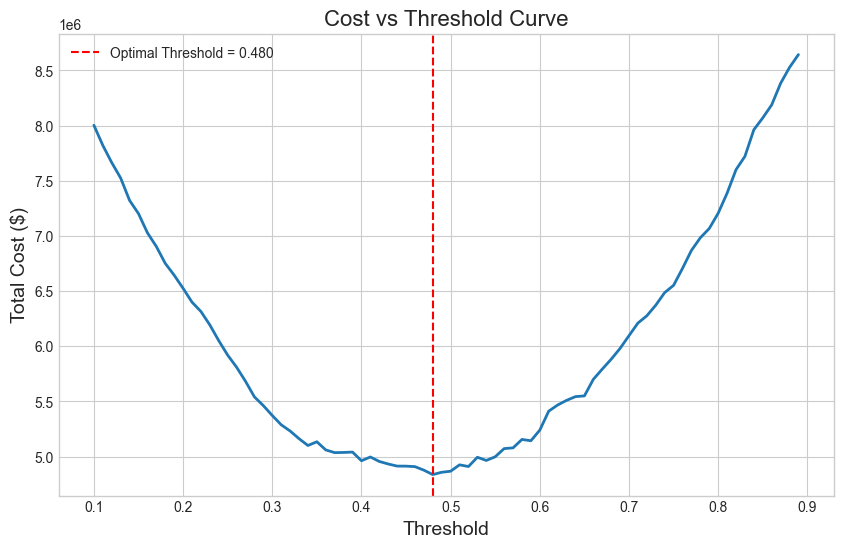

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(thresholds, costs, linewidth=2)
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f"Optimal Threshold = {optimal_threshold:.3f}")

plt.title("Cost vs Threshold Curve", fontsize=16)
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Total Cost ($)", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


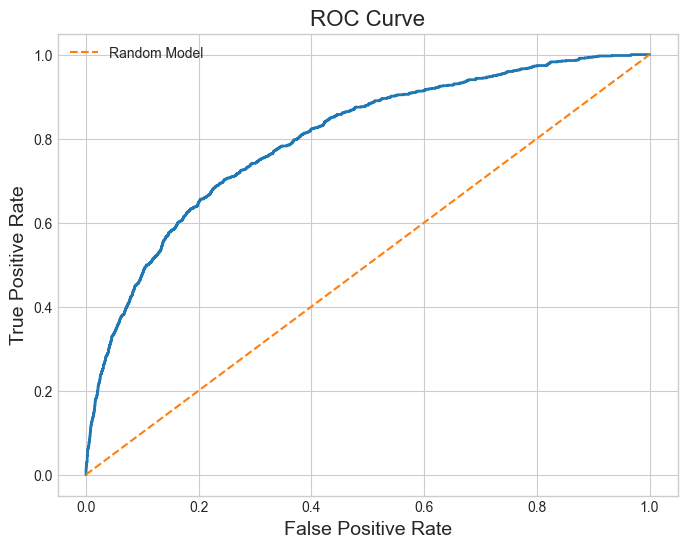

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1],[0,1],'--', label='Random Model')

plt.title("ROC Curve", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()


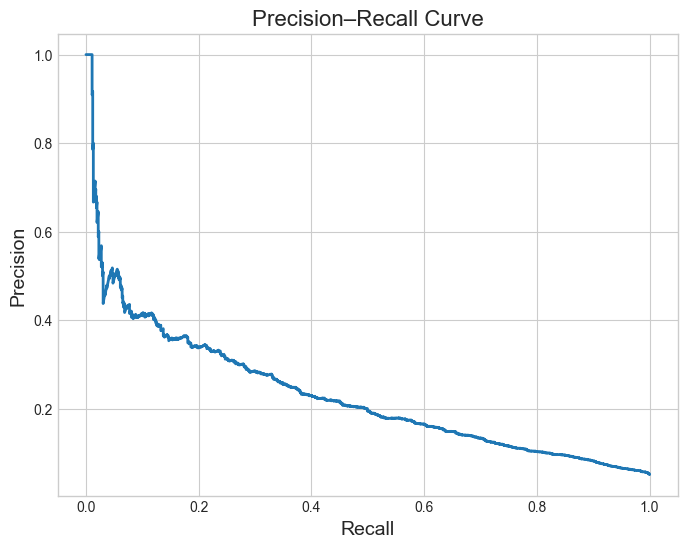

In [26]:
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_test, y_proba_test)

plt.figure(figsize=(8,6))
plt.plot(rec, prec, linewidth=2)

plt.title("Precision–Recall Curve", fontsize=16)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.grid(True)
plt.show()


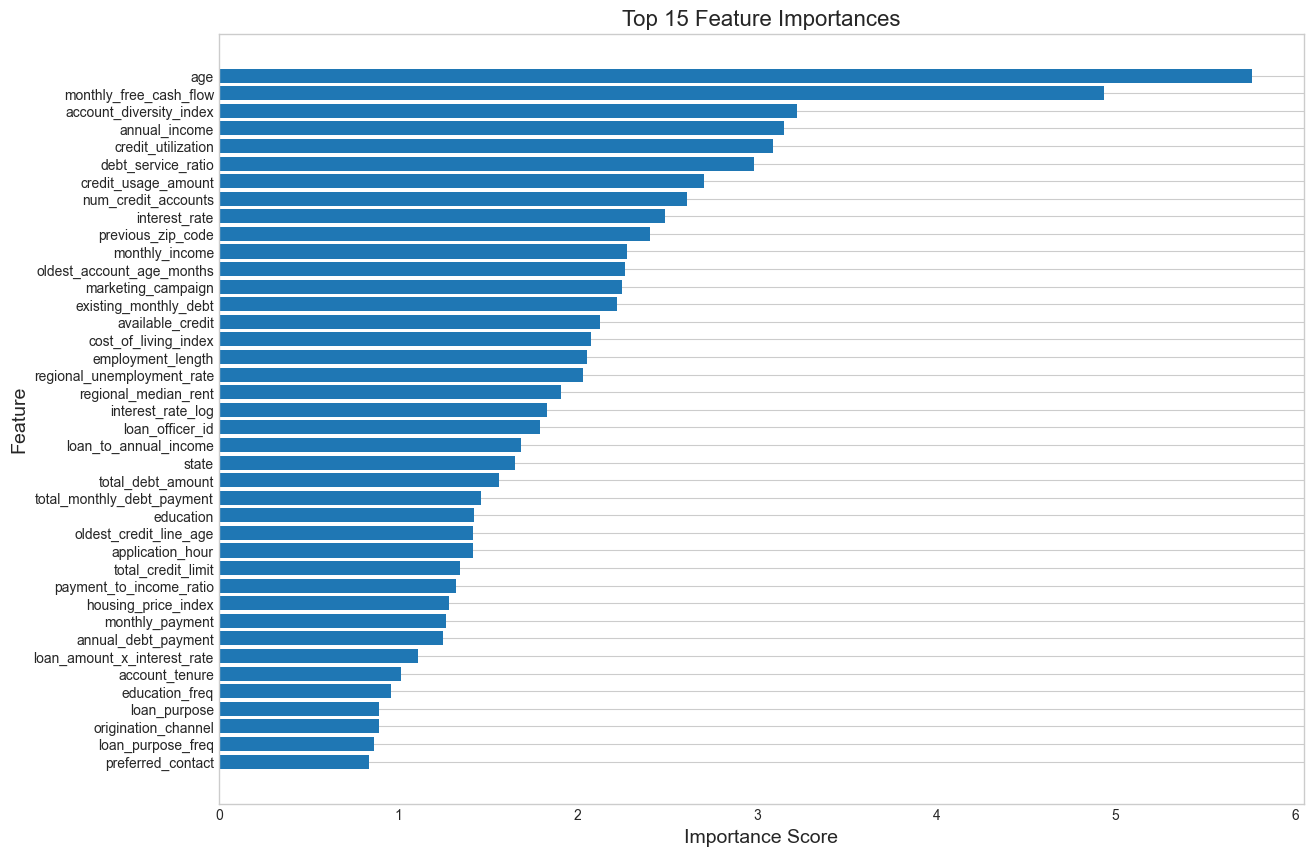

In [27]:
top15 = feature_importance.head(40)

plt.figure(figsize=(14,10))
plt.barh(top15['feature'], top15['importance'])
plt.gca().invert_yaxis()

plt.title("Top 15 Feature Importances", fontsize=16)
plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.grid(axis='x')
plt.show()


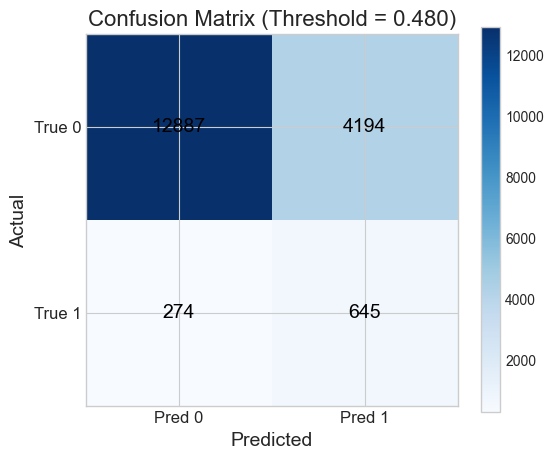

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

plt.style.use('seaborn-v0_8-whitegrid')  # Clean presentation style

# 1️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix (Threshold = {:.3f})".format(optimal_threshold), fontsize=16)
plt.colorbar()

plt.xticks([0,1], ["Pred 0", "Pred 1"], fontsize=12)
plt.yticks([0,1], ["True 0", "True 1"], fontsize=12)

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center', fontsize=14, color="black")

plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.show()